# Rain Garden Map: Flushing, Queens

## Setup

### Imports

In [30]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import re
import matplotlib.pyplot as plt

### Data Read-In

In [8]:
# Read in CSV file and remove rows 0 through 2
df = pd.read_csv("GI Assets-Grid view.csv")
df = df.iloc[3:]
df.head()

,ID,Description,Asset type,Status,Photo,Program Area,Coordinates,Record link,Stewardship,Associated partner,Garden Stewardship copy
3,753B,NaN,Rain Garden,Regular stewardship,753b.jpeg (https://v5.airtableusercontent.com/...,Corona,"40°44'45""N 73°52'05""W",NaN,"753B on Fri 12/05,753B on Fri 10/24",CASA,NaN
4,760A,NaN,Rain Garden,Regular stewardship,760a.jpeg (https://v5.airtableusercontent.com/...,Corona,"40°44'46""N 73°51'59""W",NaN,"760A on Fri 11/14,760A on Fri 12/05,760A on Fr...",CASA,NaN
5,760B,NaN,Rain Garden,Regular stewardship,NaN,Corona,"40°44'46""N 73°51'59""W",NaN,760B on Fri 12/05,CASA,NaN
6,764A,NaN,Rain Garden,Regular stewardship,764a.jpeg (https://v5.airtableusercontent.com/...,Corona,"40°44'49""N 73°52'05""W",NaN,"764A on Fri 12/05,764A on Fri 10/24",CASA,NaN
7,766B,NaN,Rain Garden,Regular stewardship,766b.jpeg (https://v5.airtableusercontent.com/...,Corona,"40°44'48""N 73°52'06""W",NaN,"766B on Fri 12/05,766B on Fri 10/24",CASA,NaN


In [9]:
def dms_to_dd(dms):
    # Match DMS like 40°44'45"N or 73°52'05"W
    match = re.match(r"""(\d+)°(\d+)'([\d.]+)"([NSEW])""", dms)
    deg, minute, sec, direction = match.groups()
    dd = float(deg) + float(minute)/60 + float(sec)/3600
    if direction in ["S", "W"]:
        dd *= -1
    return dd

# Convert DMS to decimal degrees
# Split coordinate column
coords = df["Coordinates"].str.split(" ", expand=True)
df["lat"] = coords[0].apply(dms_to_dd)
df["lon"] = coords[1].apply(dms_to_dd)

# Drop empty columns
df = df.replace(r"^\s*$", pd.NA, regex=True)
df = df.dropna(axis=1, how="all")

# Create geometry
gdf = gpd.GeoDataFrame(
    df,
    geometry=[Point(xy) for xy in zip(df.lon, df.lat)],
    crs="EPSG:4326"
)

# Export
gdf.to_file("rain_gardens.geojson", driver="GeoJSON")

In [50]:
soil = gpd.read_file("cugir-008213/NY081/spatial/soilmu_a_ny081.shp")

comp = pd.read_csv(
    "cugir-008213/NY081/tabular/comp.txt", sep="|", header=None, dtype=str
)

ncols = comp.shape[1]

comp = comp.rename(
    columns={
        2: "comppct_r",
        3: "compname",
        4: "compkind",
        79: "hydgrp",  # ← this is your A/B/C column
        ncols - 2: "mukey",
        ncols - 1: "cokey",
    }
)

comp["is_urban"] = (
    comp["compkind"].str.contains("Miscellaneous", case=False, na=False)
    | comp["compname"].str.contains("Urban", case=False, na=False)
)

native_soil = (
    comp.loc[~comp["is_urban"] & comp["hydgrp"].notna()]
        .sort_values("comppct_r", ascending=False)
        .groupby("mukey")
        .first()[["hydgrp", "compname"]]
        .rename(columns={
            "hydgrp": "hsg_native",
            "compname": "dominant_soil"
        })
)

soil["MUKEY"] = soil["MUKEY"].astype(str)

soil = soil.merge(
    native_soil,
    left_on="MUKEY",
    right_index=True,
    how="left"
)



In [61]:
# --- Load data ---
soil = gpd.read_file("cugir-008213/NY081/spatial/soilmu_a_ny081.shp")
soil["MUKEY"] = soil["MUKEY"].astype(str)

comp = pd.read_csv(
    "cugir-008213/NY081/tabular/comp.txt",
    sep="|",
    header=None,
    dtype=str,
)

# --- Rename only what we need ---
ncols = comp.shape[1]
comp = comp.rename(
    columns={
        2: "comppct_r",
        3: "compname",
        4: "compkind",
        23: "drainagecl",  # ← drainage class (string)
        79: "hydgrp",  # ← HSG
        87: "texture_class",
        ncols - 2: "mukey",
        ncols - 1: "cokey",
    }
)

# --- Flag urban components ---
comp["is_urban"] = comp["compkind"].str.contains(
    "Miscellaneous", case=False, na=False
) | comp["compname"].str.contains("Urban", case=False, na=False)


# --- Helper: dominant non-urban component per MUKEY ---
def dominant_component(df, cols):
    return (
        df.loc[~df["is_urban"]]
        .sort_values("comppct_r", ascending=False)
        .groupby("mukey")
        .first()[cols]
    )


# --- Extract native soil attributes ---
native_attrs = dominant_component(
    comp, ["hydgrp", "texture_class", "drainagecl", "compname"]
).rename(
    columns={
        "hydgrp": "hsg_native",
        "texture_class": "texture_native",
        "drainagecl": "drainage_native",
        "compname": "dominant_soil",
    }
)

# --- Join back to polygons ---
soil = soil.merge(
    native_attrs,
    left_on="MUKEY",
    right_index=True,
    how="left",
)

# --- Clean texture field ---
soil["texture_native"] = soil["texture_native"].replace("not used", None)


def simplify_texture(tex):
    if pd.isna(tex):
        return None
    tex = str(tex).lower()
    if "loam" in tex:
        return "Loamy"
    elif "sand" in tex:
        return "Sandy"
    elif "clay" in tex:
        return "Clayey"
    else:
        return "Other"


soil["texture_group"] = soil["texture_native"].apply(simplify_texture)


In [62]:
drainage_order = [
    "Excessively drained",
    "Somewhat excessively drained",
    "Well drained",
    "Moderately well drained",
    "Somewhat poorly drained",
    "Poorly drained",
    "Very poorly drained",
]

soil["drainage_native"] = pd.Categorical(
    soil["drainage_native"],
    categories=drainage_order,
    ordered=True,
)


In [65]:
print(soil)

     AREASYMBOL  SPATIALVER MUSYM    MUKEY  \
0         NY081           3   RvA  2485292   
1         NY081           3   MoC  2482937   
2         NY081           3   UFA  2518826   
3         NY081           3   UoA  2518834   
4         NY081           3   UoA  2518834   
...         ...         ...   ...      ...   
2463      NY081           3   UGA  2589206   
2464      NY081           3   UtB  2518830   
2465      NY081           3   UtB  2518830   
2466      NY081           3   UtB  2518830   
2467      NY081           3  ChAs  2481343   

                                               geometry hsg_native  \
0     POLYGON ((-73.70999 40.75511, -73.70993 40.755...          A   
1     POLYGON ((-73.71311 40.75538, -73.71316 40.755...          C   
2     POLYGON ((-73.7296 40.71975, -73.73007 40.7195...          A   
3     POLYGON ((-73.72745 40.72626, -73.72796 40.726...          B   
4     POLYGON ((-73.74549 40.71949, -73.74545 40.719...          B   
...                        

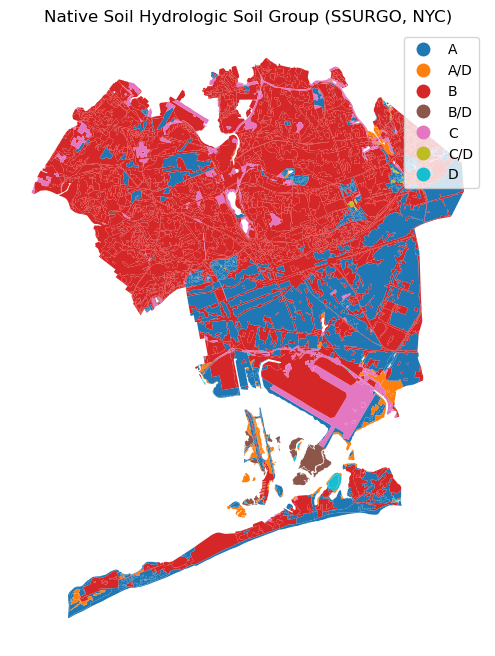

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

soil.plot(
    column="hsg_native",
    categorical=True,
    legend=True,
    ax=ax,
    edgecolor="none"
)

ax.set_title("Native Soil Hydrologic Soil Group (SSURGO, NYC)")
ax.set_axis_off()

plt.show()

In [ ]:
soil_out = soil[
    [
        "MUKEY",
        "MUSYM",
        "dominant_soil",
        "hsg_native",
        "texture_group",
        "drainage_native",
        "geometry",
    ]
].copy()

for col in [
    "MUKEY",
    "MUSYM",
    "dominant_soil",
    "hsg_native",
    "texture_group",
    "drainage_native",
]:
    soil_out[col] = soil_out[col].astype(str)


In [67]:
soil_out.to_file(
    "nyc_native_soils_for_rain_gardens.geojson",
    driver="GeoJSON"
)
